# Creating Risk of Bias Inference Dataset
-------


## Importing libraries

In [27]:
import os
import ast
import pandas as pd
import numpy as np
import json
import string
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import IterativeStratification
import matplotlib.pyplot as plt

In [52]:
from transformers import RobertaTokenizer, RobertaModel

## Constants

In [2]:
DATASET_PATH = os.path.join('D:\\', 'biomedical-datasets', 'cdsr_dataset')
CDSR_ROB_PATH = os.path.join(DATASET_PATH, 'rm5_risk_of_bias.csv')
CDSR_REF_PATH = os.path.join(DATASET_PATH, 'rm5-references.csv')

In [3]:
assert os.path.isfile(CDSR_ROB_PATH), "Arquivo rm5_risk_of_bias.csv não encontrado"
assert os.path.isfile(CDSR_REF_PATH), "Arquivo rm5-references.csv não encontrado"

In [4]:
cdsr_rob_df = pd.read_csv(CDSR_ROB_PATH)
cdsr_ref_df = pd.read_csv(CDSR_REF_PATH)

## Statistics by judgment of bias

In [30]:
len(cdsr_rob_df.id.unique())

32

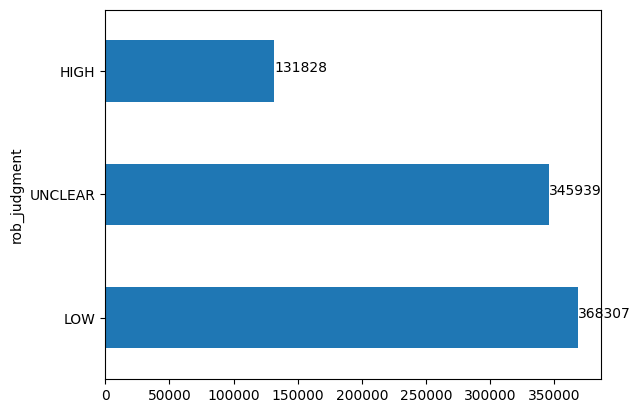

In [25]:
# plot barh for rob_judgment group by rob_judgment show values in the bar
rob_judgment = cdsr_rob_df['rob_judgment'].value_counts()
rob_judgment.plot.barh()
for index, value in enumerate(rob_judgment):
    plt.text(value, index, str(value))
plt.show()

In [28]:
def iterative_split(df, test_size, stratify_columns):
    """Custom iterative train test split which
    'maintains balanced representation with respect
    to order-th label combinations.'

    From https://madewithml.com/courses/mlops/splitting/#stratified-split
    """
    # One-hot encode the stratify columns and concatenate them
    one_hot_cols = [pd.get_dummies(df[col]) for col in stratify_columns]
    one_hot_cols = pd.concat(one_hot_cols, axis=1).to_numpy()
    stratifier = IterativeStratification(
        n_splits=2, order=len(stratify_columns), sample_distribution_per_fold=[test_size, 1-test_size])
    train_indices, test_indices = next(stratifier.split(df.to_numpy(), one_hot_cols))
    # Return the train and test set dataframes
    train, test = df.iloc[train_indices], df.iloc[test_indices]
    return train, test

In [33]:
train, val_test = iterative_split(cdsr_rob_df, 0.4, ['rob_judgment', 'id'])
val, test = iterative_split(val_test, 0.5, ['rob_judgment', 'id'])

In [34]:
train.to_csv(os.path.join(DATASET_PATH, 'rob_train.csv'), index=False)
val.to_csv(os.path.join(DATASET_PATH, 'rob_val.csv'), index=False)
test.to_csv(os.path.join(DATASET_PATH, 'rob_test.csv'), index=False)

In [35]:
train.shape, val.shape, test.shape

((507646, 14), (169213, 14), (169215, 14))

In [38]:
train.rob_judgment.value_counts(), val.rob_judgment.value_counts(), test.rob_judgment.value_counts()

(rob_judgment
 LOW        220984
 UNCLEAR    207565
 HIGH        79097
 Name: count, dtype: int64,
 rob_judgment
 LOW        73661
 UNCLEAR    69187
 HIGH       26365
 Name: count, dtype: int64,
 rob_judgment
 LOW        73662
 UNCLEAR    69187
 HIGH       26366
 Name: count, dtype: int64)

In [47]:
train.sample(100)

,review,id,name,description,core_item,level,no,study_id,study_name,group_id,group_description,rob_judgment,support_judgment,support_judgment_str
39268,D:\biomedical-datasets\cdsr_dataset\rm5\CD0010...,QIT-05,Selective reporting (reporting bias),Reporting bias due to selective outcome reporting,True,STUDY,5,STD-Dhainaut-1995,Dhainaut 1995,NaN,NaN,LOW,[],NaN
227338,D:\biomedical-datasets\cdsr_dataset\rm5\CD0043...,QIT-02,Allocation concealment (selection bias),Selection bias (biased allocation to intervent...,True,STUDY,2,STD-Mohammadi-2015,Mohammadi 2015,NaN,NaN,UNCLEAR,No information was provided to assess this risk.,No information was provided to assess this risk.
320220,D:\biomedical-datasets\cdsr_dataset\rm5\CD0061...,QIT-04,Incomplete outcome data (attrition bias),"Attrition bias due to amount, nature or handli...",True,GROUP,4,STD-Frishman-2004,Frishman 2004,QIG-04.01,All outcomes,LOW,"['Quote: ""No patients were excluded from the s...","Quote: ""No patients were excluded from the stu..."
239390,D:\biomedical-datasets\cdsr_dataset\rm5\CD0045...,QIT-06,Other bias,Bias due to problems not covered elsewhere in ...,True,STUDY,6,STD-Reid-2006,Reid 2006,NaN,NaN,UNCLEAR,"['""The extension (Protocol 907â\x80\x9310) was...","""The extension (Protocol 907â10) was a doubl..."
520028,D:\biomedical-datasets\cdsr_dataset\rm5\CD0095...,QIT-05,Incomplete outcome data (attrition bias),"Attrition bias due to amount, nature or handli...",True,GROUP,5,STD-Leslie-2017,Leslie 2017,QIG-05.02,Antimalarial prescribing to microscopy- or PCR...,LOW,"86% CHWs received training, consented and enro...","86% CHWs received training, consented and enro..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448506,D:\biomedical-datasets\cdsr_dataset\rm5\CD0082...,QIT-01,Random sequence generation (selection bias),Selection bias (biased allocation to intervent...,True,STUDY,1,STD-Latimer-2006,Latimer 2006,NaN,NaN,LOW,Randomised: stratified by work history and cli...,Randomised: stratified by work history and cli...
448554,D:\biomedical-datasets\cdsr_dataset\rm5\CD0082...,QIT-04,Incomplete outcome data (attrition bias),"Attrition bias due to amount, nature or handli...",True,GROUP,4,STD-Wong-2008,Wong 2008,QIG-04.01,All outcomes,LOW,Number and reason for attrition reported. One ...,Number and reason for attrition reported. One ...
834905,D:\biomedical-datasets\cdsr_dataset\rm5\CD0148...,QIT-04,Incomplete outcome data (attrition bias),"Attrition bias due to amount, nature or handli...",True,GROUP,4,STD-Rayes-2005,Rayes 2005,QIG-04.01,All outcomes,LOW,"{'B': 'Comment', '#text': ': attrition = 0%'}",: attrition = 0%
351222,D:\biomedical-datasets\cdsr_dataset\rm5\CD0065...,QIT-05,Selective reporting (reporting bias),Reporting bias due to selective outcome reporting,True,STUDY,5,STD-Yu-2008,Yu 2008,NaN,NaN,HIGH,"Data on TESS score, blood and urine routine, a...","Data on TESS score, blood and urine routine, a..."


## Tokenizing and padding

In [50]:
x_train = train[['name', 'description', 'support_judgment_str']].fillna('')
y_train = train['rob_judgment']

In [51]:
x_train['hypothesis'] = x_train['name'] + ' ' + x_train['description']
x_train['premise'] = x_train['support_judgment_str']

In [53]:
tokenizer = RobertaTokenizer.from_pretrained('allenai/biomed_roberta_base')

In [55]:
hypotheses_tokens = x_train['hypothesis'].apply(tokenizer.encode)
premises_tokens = x_train['premise'].apply(tokenizer.encode)

Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors


In [59]:
x_train['h_tkn_count'] = hypotheses_tokens.apply(len)
x_train['p_tkn_count'] = premises_tokens.apply(len)

array([[<Axes: title={'center': 'h_tkn_count'}>,
        <Axes: title={'center': 'p_tkn_count'}>]], dtype=object)

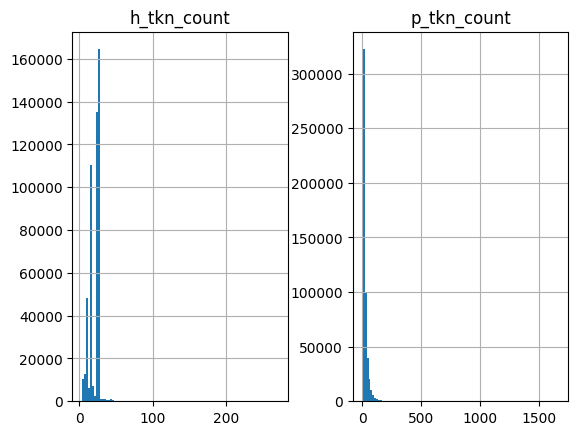

In [63]:
x_train[['h_tkn_count', 'p_tkn_count']].hist(bins=100)

In [62]:
x_train[['h_tkn_count', 'p_tkn_count']].describe()

,h_tkn_count,p_tkn_count
count,507646.000000,507646.000000
mean,21.936158,21.650384
std,9.739229,27.673674
min,4.000000,2.000000
25%,15.000000,6.000000
50%,25.000000,13.000000
75%,26.000000,27.000000
max,271.000000,1664.000000
